# Random Graph Experimentation - Comparing RobustPC variants vs PC algorithm

We hypothesize that RobustPC in the context of **faithful** and/or **m-strong-faithful** graphs will perform better than the naive PC algorithm. The baseline CPDAG we want to compare to is the one using a ParentOracle, which is uniformly consistent for all graphs.

We have the following comparisons that leverage the momentary conditional independence condition (MCI), which leverages a fixed conditioning set in addition to that suggested via PC:

    - definite parents: Using a parent oracle
    - definite children: Using a children oracle
    - definite parents + definite children: Using a parent + children oracle
    - definite Markov blanket: Using the markov blanket oracle
    - estimated parents: using "some" procedure to estimate the parents
    - estimated parents + children: using "some" procedure to estimate the parents+children
    - estimated markov blanket: estimating the markov blanket
    
References
----------
[1] https://www.jmlr.org/papers/volume9/pellet08a/pellet08a.pdf

In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from pathlib import Path
from pprint import pprint
import json

import numpy as np
import bnlearn as bn
import networkx as nx
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score

import causal_networkx
from causal_networkx.ci import (
    FisherZCITest,
    GSquareCITest,
    PartialCorrelation,
    Oracle,
    ParentChildOracle,
)
from causal_networkx.discovery import PC, RobustPC
from causal_networkx.io import read_dot, load_from_networkx
from causal_networkx.io import read_gml
from causal_networkx.metrics import (
    structure_hamming_dist,
    graph_to_pred_vector,
    confusion_matrix_networks,
)

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
np.random.seed(12345)

# Set up to load the data

The data should have been previously generated via the manm_cs package for additive noise models. We will load the data in with specific parameters.

In [5]:
data_dir = Path("/Volumes/Extreme Pro/structure_learning_manm_sim")

In [6]:
n_datasets = len(list(data_dir.glob("*.csv")))
print(n_datasets)

899


# Analyze the Data

In [34]:
ci_est = "parcorr"
ci_estimator = PartialCorrelation(method="pingouin")

ci_est = "fisherz"
ci_estimator = FisherZCITest()

In [39]:
for idx in range(n_datasets):
    data_fname = data_dir / "data" / f"graph_{idx}.csv"
    graph_fname = data_dir / "data" / f"graph_{idx}.gml"
    meta_fname = data_dir / "data" / f"graph_{idx}.json"

    if not data_fname.exists():
        continue
    # load the actual data
    df = pd.read_csv(data_fname, index_col=0)
    nx_graph = nx.read_gml(graph_fname)
    true_graph = load_from_networkx(nx_graph)
    with open(meta_fname, "r") as fin:
        meta_dict = json.load(fin)

    # sub-sample data
    df = df.sample(2000)

    ###### PC ALGORITHM BENCHMARKS ########
    # run the PC algorithm with Oracle
    # oracle = Oracle(true_graph)
    # pc_oracle = PC(ci_estimator=oracle)
    # pc_oracle.fit(df)
    # oracle_graph = pc_oracle.graph_
    # fname = data_dir / "output" / f"graph_oracle_{ci_est}_{idx}.gml"
    # oracle_graph.save(fname, format="networkx-gml")

    # run the PC algorithm with partial correlation
    # pc_alg = PC(ci_estimator=ci_estimator)
    # pc_alg.fit(df)
    # pc_graph = pc_alg.graph_
    # fname = data_dir / "output" / f"graph_pcalg_{ci_est}_{idx}.gml"
    # pc_graph.save(fname, format="networkx-gml")

    # plt.figure()
    # pc_graph.draw()

    ###### ROBUSTPC ALGORITHM PART ########
    # run the RobustPC algorithm with partial correlation with ParentOracle
    partial_knowledge = ParentChildOracle(true_graph)
    robustpc = RobustPC(
        ci_estimator=ci_estimator,
        partial_knowledge=partial_knowledge,
        skip_first_stage=True,
        use_children=False,
    )

    robustpc.fit(df)
    graph = robustpc.graph_
    fname = data_dir / "output_v3" / f"graph_robust_defparents_{ci_est}_{idx}.gml"
    graph.save(fname, format="networkx-gml")

    # run the RobustPC algorithm with partial correlation with ParentChildrenOracle
    partial_knowledge = ParentChildOracle(true_graph)
    robustpc = RobustPC(
        ci_estimator=ci_estimator,
        partial_knowledge=partial_knowledge,
        skip_first_stage=True,
        use_children=True,
    )
    robustpc.fit(df)
    graph = robustpc.graph_
    fname = (
        data_dir / "output_v3" / f"graph_robust_defparentschildren_{ci_est}_{idx}.gml"
    )
    graph.save(fname, format="networkx-gml")

    # run the RobustPC algorithm with ChildrenOracle
    partial_knowledge = ParentChildOracle(true_graph)
    robustpc = RobustPC(
        ci_estimator=ci_estimator,
        partial_knowledge=partial_knowledge,
        skip_first_stage=True,
        use_children=True,
        use_parents=False,
    )
    robustpc.fit(df)
    graph = robustpc.graph_
    fname = data_dir / "output_v3" / f"graph_robust_defchildren_{ci_est}_{idx}.gml"
    graph.save(fname, format="networkx-gml")
    # break

In [11]:
oracle_graph.draw()
print(idx)
print(structure_hamming_dist(oracle_graph, pc_graph))
print(structure_hamming_dist(oracle_graph, graph))

NameError: name 'oracle_graph' is not defined

In [40]:
print(df.shape)
df = df.sample(2000)
print(df.shape)
display(df.head())
print(true_graph.nodes)

(2000, 14)
(2000, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
57460,-0.226345,4.260160,3.341793,-8.282573,-9.642568,17.443113,20.933627,-34.244296,-0.297983,40.475122,-77.495652,64.824927,130.963468,-85.620771
22844,-4.332856,-4.994205,-4.236844,6.667820,0.697222,-7.122689,4.207426,-0.685306,9.827723,15.025422,15.212173,-32.958810,-9.054509,40.685611
33018,0.737356,-0.018982,-2.790021,2.485185,6.293829,-5.907269,-2.745034,15.034834,-0.654384,-16.769657,26.180105,-15.924452,-49.402190,14.089975
25836,0.776148,2.665610,7.012655,-4.170080,-1.886510,0.589791,-4.569532,2.197599,-14.613891,-16.792834,-9.765436,21.612801,-3.275444,-33.826190
54107,-0.677432,0.117549,3.690308,-2.936810,1.973310,4.734627,-2.794219,1.472719,-2.386342,-3.606217,-3.602203,9.006254,5.579282,-6.735944


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']


In [18]:
print(true_graph.edges)

[('0', '1'), ('0', '2'), ('0', '3'), ('0', '4'), ('0', '5'), ('0', '6'), ('0', '7'), ('0', '8'), ('0', '9'), ('0', '10'), ('0', '12'), ('0', '13'), ('1', '2'), ('1', '3'), ('1', '6'), ('1', '8'), ('1', '9'), ('1', '10'), ('1', '11'), ('1', '12'), ('1', '13'), ('2', '5'), ('2', '6'), ('2', '7'), ('2', '8'), ('2', '9'), ('2', '10'), ('2', '11'), ('2', '12'), ('2', '13'), ('3', '4'), ('3', '5'), ('3', '6'), ('3', '7'), ('3', '8'), ('3', '9'), ('3', '10'), ('3', '12'), ('3', '13'), ('4', '5'), ('4', '6'), ('4', '7'), ('4', '8'), ('4', '9'), ('4', '10'), ('4', '12'), ('4', '13'), ('5', '6'), ('5', '7'), ('5', '8'), ('5', '9'), ('5', '10'), ('5', '11'), ('5', '12'), ('5', '13'), ('6', '7'), ('6', '8'), ('6', '9'), ('6', '10'), ('6', '11'), ('6', '12'), ('7', '8'), ('7', '9'), ('7', '10'), ('7', '11'), ('7', '12'), ('7', '13'), ('8', '9'), ('8', '10'), ('8', '12'), ('8', '13'), ('9', '11'), ('9', '12'), ('9', '13'), ('10', '11'), ('10', '12'), ('10', '13'), ('11', '12'), ('11', '13'), ('12', 

# Analyze Output of the Different Algorithms

For every graph, re-load in the graphs that were learned and compare against the benchmark: the Oracle setting.

Use the confusion matrix and ROC_auc.

In [26]:
oracle_vec = graph_to_pred_vector(oracle_graph)
#         graph_vec = graph_to_pred_vector(graph)
print(oracle_vec)

[1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]


In [122]:
ci_est = "parcorr"

In [58]:
def false_positive_rate(y_true, y_pred):

    # false positive
    fp = ((y_pred == 1) & (y_true == 0)).sum()

    # true negative
    tn = ((y_pred == 0) & (y_true == 0)).sum()

    # false positive rate
    return fp / (fp + tn)

In [65]:
perf_df = pd.DataFrame()

for idx in range(n_datasets):
    # load the metadata
    meta_fname = data_dir / "data" / f"graph_{idx}.json"
    if not meta_fname.exists():
        continue
    with open(meta_fname, "r") as fin:
        meta_dict = json.load(fin)

    # load the oracle
    oracle_graph_fname = (
        data_dir / "output_benchmark" / f"graph_oracle_{ci_est}_{idx}.gml"
    )
    oracle_graph = read_gml(oracle_graph_fname)

    perf_dict = meta_dict.copy()
    perf_dict["n_edges"] = oracle_graph.to_adjacency_graph().number_of_edges()

    for name in [
        "pcalg",
        "robust_defparents",
        "robust_defparentschildren",
        "robust_defchildren",
    ]:
        if name == "pcalg":
            graph_fname = (
                data_dir / "output_benchmark" / f"graph_{name}_{ci_est}_{idx}.gml"
            )
        else:
            graph_fname = data_dir / "output_v3" / f"graph_{name}_{ci_est}_{idx}.gml"

        # load in the graph
        graph = read_gml(graph_fname)

        # compare the graphs
        shd = structure_hamming_dist(oracle_graph, graph, double_for_anticausal=True)
        perf_dict[f"shd-{name}"] = shd
        shd = structure_hamming_dist(oracle_graph, graph, double_for_anticausal=False)
        perf_dict[f"shdnorm-{name}"] = shd

        # compute the confusion matrix
        # tn, fp, fn, tp = confusion_matrix_networks(oracle_graph, graph).ravel()
        # perf_dict[f"ppv-{name}"] = tp / (tp + fp)
        # perf_dict[f"npv-{name}"] = tn / (tn + fn)
        # perf_dict[f"tpr-{name}"] = tp / (tp + fn)
        # perf_dict[f"fpr-{name}"] = fp / (fp + tn)

        # compute true positive rate and false positive rate
        oracle_vec = graph_to_pred_vector(oracle_graph, sort_first=True)
        graph_vec = graph_to_pred_vector(graph, sort_first=True)

        ppv = precision_score(oracle_vec, graph_vec, pos_label=1)
        npv = precision_score(oracle_vec, graph_vec, pos_label=0)
        perf_dict[f"ppv-{name}"] = ppv
        perf_dict[f"npv-{name}"] = npv

        tpr = recall_score(oracle_vec, graph_vec, pos_label=1)
        tnr = recall_score(oracle_vec, graph_vec, pos_label=0)
        fpr = false_positive_rate(oracle_vec, graph_vec)
        perf_dict[f"tpr-{name}"] = tpr
        perf_dict[f"tnr-{name}"] = tnr
        perf_dict[f"fpr-{name}"] = fpr

    _perf_df = pd.DataFrame.from_dict(perf_dict)
    perf_df = pd.concat((perf_df, _perf_df))
display(perf_df.head())
# break

,idx,n_nodes,n_samples,edge_density,discrete_node_ratio,conditional_gaussian,discrete_signal_to_noise_ratio,min_discrete_value_classes,max_discrete_value_classes,continuous_noise_std,...,ppv-robust_defparentschildren,npv-robust_defparentschildren,tpr-robust_defparentschildren,fpr-robust_defparentschildren,shd-robust_defchildren,shdnorm-robust_defchildren,ppv-robust_defchildren,npv-robust_defchildren,tpr-robust_defchildren,fpr-robust_defchildren
0,0,5,500000,0.1,0.0,True,0.9,3,4,0.100000,...,0.0,1.0,0.0,0.1,1.0,1.0,0.0,1.0,0.0,0.1
0,1,5,500000,0.1,0.0,True,0.9,3,4,0.422222,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,2,5,500000,0.1,0.0,True,0.9,3,4,0.744444,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,3,5,500000,0.1,0.0,True,0.9,3,4,1.066667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,4,5,500000,0.1,0.0,True,0.9,3,4,1.388889,...,0.0,1.0,0.0,0.2,2.0,2.0,0.0,1.0,0.0,0.2


In [60]:
print(graph_vec)

[1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [61]:
from pprint import pprint

pprint(perf_df.columns)

Index(['idx', 'n_nodes', 'n_samples', 'edge_density', 'discrete_node_ratio',
       'conditional_gaussian', 'discrete_signal_to_noise_ratio',
       'min_discrete_value_classes', 'max_discrete_value_classes',
       'continuous_noise_std', 'beta_lower_limit', 'beta_upper_limit',
       'functions_prob', 'functions', 'n_edges', 'shd-pcalg', 'ppv-pcalg',
       'npv-pcalg', 'tpr-pcalg', 'fpr-pcalg', 'shd-robust_defparents',
       'ppv-robust_defparents', 'npv-robust_defparents',
       'tpr-robust_defparents', 'fpr-robust_defparents',
       'shd-robust_defparentschildren', 'ppv-robust_defparentschildren',
       'npv-robust_defparentschildren', 'tpr-robust_defparentschildren',
       'fpr-robust_defparentschildren', 'shd-robust_defchildren',
       'ppv-robust_defchildren', 'npv-robust_defchildren',
       'tpr-robust_defchildren', 'fpr-robust_defchildren'],
      dtype='object')


In [66]:
fname = data_dir / "summary_v3" / f"performance_summary_{ci_est}_850_runs.csv"
fname.parent.mkdir(exist_ok=True, parents=True)
perf_df.to_csv(fname)

print(perf_df.shape)

(898, 39)


In [67]:
ci_est = "fisherz"
fname = data_dir / "summary_v3" / f"performance_summary_{ci_est}_850_runs.csv"
perf_df = pd.read_csv(fname)

In [24]:
# perf_df["shd-diff"] = perf_df["shd-robust_defparents"] - perf_df["shd-pcalg"]
perf_df["shd-diff"] = perf_df["shd-robust_defparentschildren"] - perf_df["shd-pcalg"]

[Text(0.5, 1.0, 'shd of Detection of Edges'),
 Text(0.5, 0, 'Number of edges'),
 Text(0, 0.5, '$\\Delta$-shd \n(Robust-defparents - PC)')]

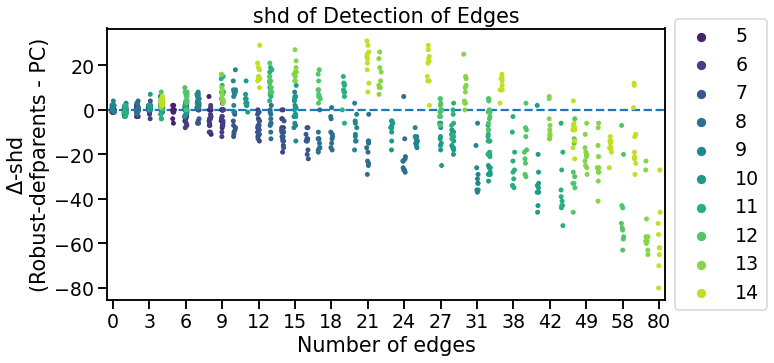

In [68]:
metric = "shd"
mciname = "defparents"
# mciname = "defparentschildren"
# mciname = "defchildren"

perf_df[f"{metric}-{mciname}-diff"] = (
    perf_df[f"{metric}-robust_{mciname}"] - perf_df[f"{metric}-pcalg"]
)
sns.set_context("talk", font_scale=1.15)

fig, ax = plt.subplots(figsize=(10, 5))
g = sns.stripplot(
    x="n_edges",
    y=f"{metric}-{mciname}-diff",
    # color="red",
    hue="n_nodes",
    palette="viridis",
    data=perf_df,
    ax=ax,
)
# Put the legend out of the figure
g.legend(loc="center left", bbox_to_anchor=(1, 0.5))

ax.axhline([0], ls="--")
x = perf_df["n_edges"]
xticks = ax.get_xticks()
ax.set_xticks(xticks[::3])
ax.set(
    title=f"{metric} of Detection of Edges",
    xlabel="Number of edges",
    ylabel=f"$\Delta$-{metric} \n(Robust-{mciname} - PC)",
)

# fig.savefig(
#     data_dir / "figures" / f"{metric}_{mciname}-pc_nedges.pdf", bbox_inches="tight"
# )

[Text(0.5, 1.0, 'shdnorm of Detection of Edges'),
 Text(0.5, 0, 'Number of edges'),
 Text(0, 0.5, '$\\Delta$-shdnorm \n(Robust-defparents - PC)')]

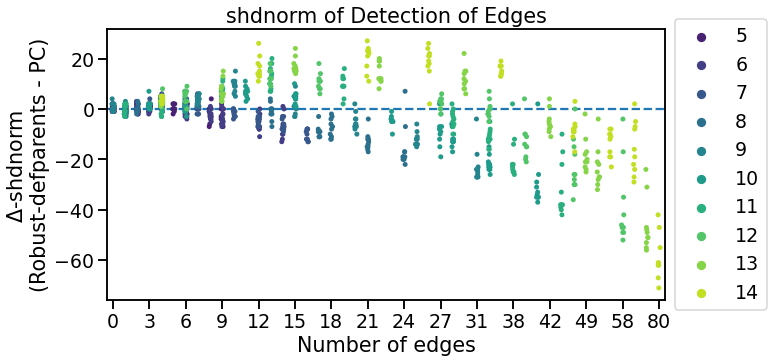

In [69]:
metric = "shdnorm"
mciname = "defparents"
# mciname = "defparentschildren"
# mciname = "defchildren"

perf_df[f"{metric}-{mciname}-diff"] = (
    perf_df[f"{metric}-robust_{mciname}"] - perf_df[f"{metric}-pcalg"]
)
sns.set_context("talk", font_scale=1.15)

fig, ax = plt.subplots(figsize=(10, 5))
g = sns.stripplot(
    x="n_edges",
    y=f"{metric}-{mciname}-diff",
    # color="red",
    hue="n_nodes",
    palette="viridis",
    data=perf_df,
    ax=ax,
)
# Put the legend out of the figure
g.legend(loc="center left", bbox_to_anchor=(1, 0.5))

ax.axhline([0], ls="--")
x = perf_df["n_edges"]
xticks = ax.get_xticks()
ax.set_xticks(xticks[::3])
ax.set(
    title=f"{metric} of Detection of Edges",
    xlabel="Number of edges",
    ylabel=f"$\Delta$-{metric} \n(Robust-{mciname} - PC)",
)

# fig.savefig(
#     data_dir / "figures" / f"{metric}_{mciname}-pc_nedges.pdf", bbox_inches="tight"
# )

[Text(0.5, 1.0, 'fpr of Detection of Edges'),
 Text(0.5, 0, 'Number of edges'),
 Text(0, 0.5, '$\\Delta$-fpr \n(Robust-defparents - PC)')]

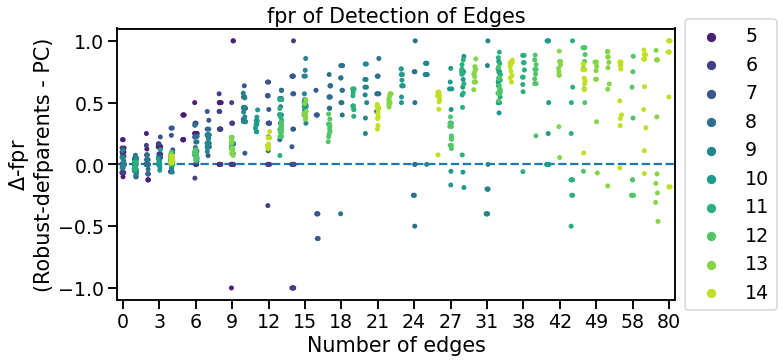

In [64]:
metric = "fpr"
mciname = "defparents"
# mciname = "defparentschildren"
# mciname = "defchildren"

perf_df[f"{metric}-{mciname}-diff"] = (
    perf_df[f"{metric}-robust_{mciname}"] - perf_df[f"{metric}-pcalg"]
)
sns.set_context("talk", font_scale=1.15)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_facecolor("white")
g = sns.stripplot(
    hue="n_nodes",
    palette="viridis",
    x="n_edges",
    y=f"{metric}-{mciname}-diff",
    # color="red",
    data=perf_df,
    ax=ax,
)
ax.axhline([0], ls="--")

# Put the legend out of the figure
g.legend(loc="center left", bbox_to_anchor=(1, 0.5))
xticks = ax.get_xticks()
ax.set_xticks(xticks[::3])

ax.set(
    title=f"{metric} of Detection of Edges",
    xlabel="Number of edges",
    ylabel=f"$\Delta$-{metric} \n(Robust-{mciname} - PC)",
)
# fig.savefig(
#     data_dir / "figures" / f"{metric}_{mciname}-pc_nedges.pdf", bbox_inches="tight"
# )

[Text(0.5, 1.0, 'tpr of Detection of Edges'),
 Text(0.5, 0, 'Number of edges'),
 Text(0, 0.5, '$\\Delta$-tpr \n(Robust-defparents - PC)')]

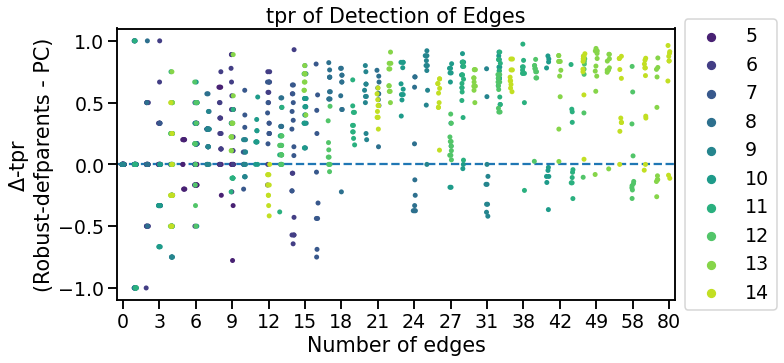

In [56]:
metric = "tpr"
mciname = "defparents"
# mciname = "defparentschildren"
# mciname = "defchildren"

perf_df[f"{metric}-{mciname}-diff"] = (
    perf_df[f"{metric}-robust_{mciname}"] - perf_df[f"{metric}-pcalg"]
)
sns.set_context("talk", font_scale=1.15)

fig, ax = plt.subplots(figsize=(10, 5))
g = sns.stripplot(
    hue="n_nodes",
    palette="viridis",
    x="n_edges",
    y=f"{metric}-{mciname}-diff",
    # color="red",
    data=perf_df,
    ax=ax,
)
ax.axhline([0], ls="--")

# Put the legend out of the figure
g.legend(loc="center left", bbox_to_anchor=(1, 0.5))
xticks = ax.get_xticks()
ax.set_xticks(xticks[::3])

ax.set(
    title=f"{metric} of Detection of Edges",
    xlabel="Number of edges",
    ylabel=f"$\Delta$-{metric} \n(Robust-{mciname} - PC)",
)
# fig.savefig(
#     data_dir / "figures" / f"{metric}_{mciname}-pc_nedges.pdf", bbox_inches="tight"
# )

In [ ]:
metric = "tpr"
mciname = "defparents"
# mciname = "defparentschildren"
# mciname = "defchildren"

perf_df[f"{metric}-{mciname}-diff"] = (
    perf_df[f"{metric}-robust_{mciname}"] - perf_df[f"{metric}-pcalg"]
)
sns.set_context("talk", font_scale=1.15)

fig, ax = plt.subplots(figsize=(10, 5))
g = sns.stripplot(
    hue="n_nodes",
    palette="viridis",
    x="n_edges",
    y=f"{metric}-{mciname}-diff",
    # color="red",
    data=perf_df,
    ax=ax,
)
ax.axhline([0], ls="--")

# Put the legend out of the figure
g.legend(loc="center left", bbox_to_anchor=(1, 0.5))
xticks = ax.get_xticks()
ax.set_xticks(xticks[::3])

ax.set(
    title=f"{metric} of Detection of Edges",
    xlabel="Number of edges",
    ylabel=f"$\Delta$-{metric} \n(Robust-{mciname} - PC)",
)
# fig.savefig(
#     data_dir / "figures" / f"{metric}_{mciname}-pc_nedges.pdf", bbox_inches="tight"
# )

## Discussion on FPR outliers

Looking at the corresponding TPR/FPR figure, we see that at the lower number of edges, there are some graphs that PC completely dominates. Specifically for the FPR case, we will investigate the graphs, where the delta is large.

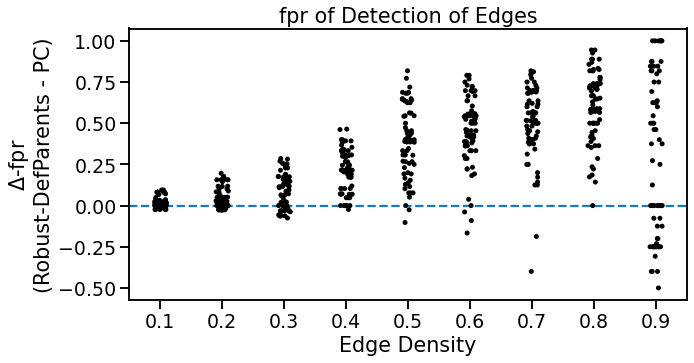

In [76]:
metric = "fpr"
param = "edge_density"
mciname = "defparents"

perf_df[f"{metric}-{mciname}-diff"] = (
    perf_df[f"{metric}-robust_{mciname}"] - perf_df[f"{metric}-pcalg"]
)

sns.set_context("talk", font_scale=1.15)
perf_df["edge_density"] = perf_df["edge_density"].round(2)
fig, ax = plt.subplots(figsize=(10, 5))
g = sns.stripplot(
    # hue="n_edges",
    # palette="viridis",
    color="black",
    x=param,
    y=f"{metric}-{mciname}-diff",
    data=perf_df,
    ax=ax,
)
ax.axhline([0], ls="--")

ax.set(
    title=f"{metric} of Detection of Edges",
    xlabel="Edge Density",
    ylabel=f"$\Delta$-{metric} \n(Robust-{mciname} - PC)",
)
fig.savefig(
    data_dir / "figures" / f"{metric}_{mciname}-pc_{param}.pdf", bbox_inches="tight"
)

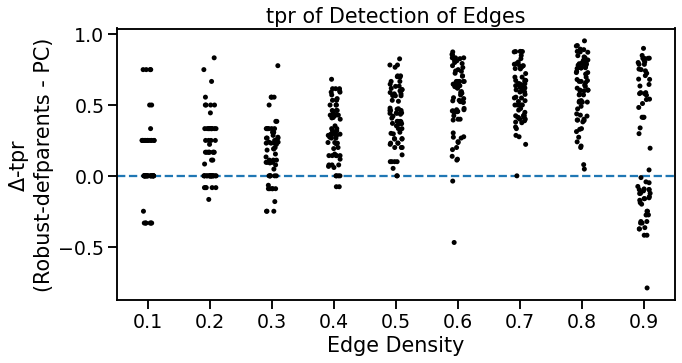

In [77]:
metric = "tpr"
param = "edge_density"
mciname = "defparents"

perf_df[f"{metric}-{mciname}-diff"] = (
    perf_df[f"{metric}-robust_{mciname}"] - perf_df[f"{metric}-pcalg"]
)

sns.set_context("talk", font_scale=1.15)
perf_df["edge_density"] = perf_df["edge_density"].round(2)
fig, ax = plt.subplots(figsize=(10, 5))
g = sns.stripplot(
    # hue="n_edges",
    # palette="viridis",
    color="black",
    x=param,
    y=f"{metric}-{mciname}-diff",
    data=perf_df,
    ax=ax,
)
ax.axhline([0], ls="--")

ax.set(
    title=f"{metric} of Detection of Edges",
    xlabel="Edge Density",
    ylabel=f"$\Delta$-{metric} \n(Robust-{mciname} - PC)",
)
fig.savefig(
    data_dir / "figures" / f"{metric}_{mciname}-pc_{param}.pdf", bbox_inches="tight"
)

[31 24 16 16 12 14  9 14 14]
[9 8 7 7 6 6 5 6 6]


,Unnamed: 0,idx,n_nodes,n_samples,edge_density,discrete_node_ratio,conditional_gaussian,discrete_signal_to_noise_ratio,min_discrete_value_classes,max_discrete_value_classes,...,tpr-robust_defparents,fpr-robust_defparents,shd-robust_defparentschildren,ppv-robust_defparentschildren,npv-robust_defparentschildren,tpr-robust_defparentschildren,fpr-robust_defparentschildren,shd-diff,fpr-diff,tpr-diff
439,0,440,9,500000,0.9,0.0,True,0.9,3,4,...,0.000000,1.0,37.0,0.892857,0.250000,0.806452,0.400000,-29.0,0.400000,-0.161290
357,0,358,8,500000,0.9,0.0,True,0.9,3,4,...,0.000000,1.0,40.0,0.850000,0.125000,0.708333,0.250000,-26.0,0.500000,-0.250000
268,0,269,7,500000,0.9,0.0,True,0.9,3,4,...,0.000000,1.0,5.0,0.000000,0.238095,0.000000,1.000000,-16.0,0.600000,-0.500000
267,0,268,7,500000,0.9,0.0,True,0.9,3,4,...,0.000000,1.0,5.0,0.000000,0.238095,0.000000,1.000000,-17.0,0.600000,-0.687500
163,0,163,6,500000,0.8,0.0,True,0.9,3,4,...,0.666667,1.0,10.0,0.666667,0.111111,0.333333,0.333333,-13.0,0.666667,0.250000
175,0,175,6,500000,0.9,0.0,True,0.9,3,4,...,0.000000,1.0,1.0,0.000000,0.066667,0.000000,1.000000,-9.0,1.000000,-0.357143
84,0,84,5,500000,0.9,0.0,True,0.9,3,4,...,0.000000,1.0,4.0,0.888889,0.000000,0.888889,0.000000,-8.0,1.000000,-0.333333
170,0,170,6,500000,0.9,0.0,True,0.9,3,4,...,0.500000,1.0,6.0,0.900000,0.000000,0.642857,0.000000,-7.0,1.000000,0.428571
176,0,176,6,500000,0.9,0.0,True,0.9,3,4,...,0.000000,1.0,1.0,0.000000,0.066667,0.000000,1.000000,-14.0,1.000000,-0.571429


[('0', '1'), ('0', '2'), ('0', '3'), ('0', '4'), ('0', '5'), ('1', '2'), ('1', '3'), ('1', '4'), ('1', '5'), ('2', '3'), ('2', '4'), ('2', '5'), ('3', '4'), ('4', '5')]


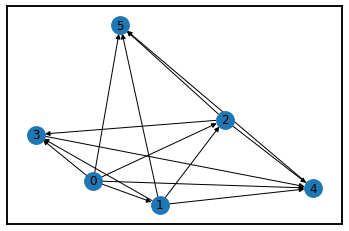

In [35]:
metric = "fpr"
metric_sort_idx = perf_df[f"{metric}-diff"].argsort().values

# get the worst performing graph and its metadata for RobustPC
meta_df = pd.DataFrame(perf_df.iloc[metric_sort_idx[-10:-1]])
print(meta_df["n_edges"].values)
print(meta_df["n_nodes"].values)
display(meta_df)

idx = metric_sort_idx[-1]
graph_fname = data_dir / f"graph_{idx}.gml"
true_graph = read_gml(graph_fname)

print(true_graph)
print(true_graph.edges)
true_graph.draw()

### Discussion Notes 6/17/22 w/ Adele:

For new results, we want to investigate "how to estimate the parents", to make these results work in practice:

#### Background knowledge

    - partial/ancestral order (non-ancestor, possible/potential-ancestor, definite-ancestor, definite non-descendant, ): 
        - something to check: conditioning on a neighbor that is connected by bidirected edge in FCI-algorithm, is this a problem? Since conditioning on children probably decreases performance.
        - E.g. in an adjacency discovery phase, adjacent variables can be: i) parent/child, ii) (in semi-markovian case) ancestor/descendant, or iii) (in semi-markovian case) bidirected edge.
    
Example: Definite non-descendant knowledge of B is definitely non-descendant of A, in PAG during middle of FCI. Say the variables, {A, B} are adjacent, then B *-> A, where it could mean: B -> A, or B <-> A. Note in the case of Markovian, it would definitely be B -> A.
    
#### More data
- using interventions: to estimate ancestral/descendant relationships
    - E.g. inversion of R3 of do-calc is related to partial order
        - if y is before 'x' and you intervene on 'x', then if R3 applies, then you would see that y has "no response" relative to the intervention of 'x'.
        - TODO: re-read Amin's paper, on what is said about R2/3.
        - TODO: think about some examples, where the R2/3 gives us more than just CI we get some partial knowledge
        - 'x' <- 'y': now if we intervene on 'x', then P(y | do(x)) = P(y) under R3
            - 'x' <--> 'y' or 'x' 'y'
            - in english: 'y' is not a descendant of 'x' and we "see" this after some intervention.
        - 'x' <- 'y' <- 'z': now if we intervene on 'x', then P(y | do(x), z) = P(y | z) under R3
        - 'z' <- 'x' <- 'y',:  now if we intervene on 'x', then P(y | do(x)) = P(y) under R3, but also P(z | do(x)) \neq P(z)
        - in semi-markov: if 'z' is a collider...

#### Iterations of algorithm(s):
- running PC algorithm multiple times
- score-based algorithms

[Text(0.5, 1.0, 'npv of Detection of Edges'),
 Text(0.5, 0, 'Number of nodes'),
 Text(0, 0.5, '$\\Delta$-npv \n(Robust-DefParents - PC)')]

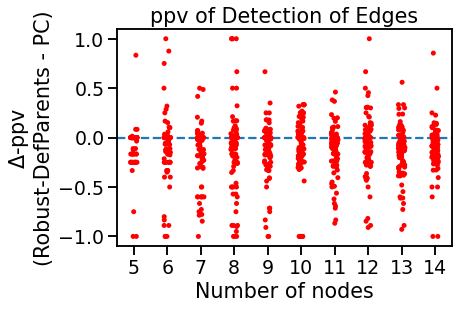

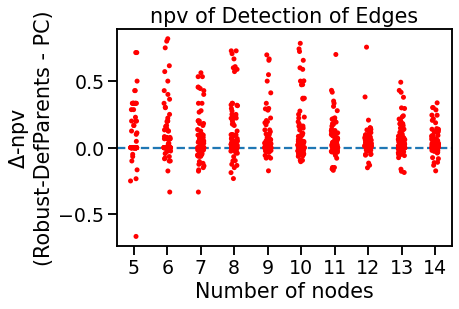

In [135]:
metric = "ppv"
perf_df[f"{metric}-diff"] = (
    perf_df[f"{metric}-robust_defparents"] - perf_df[f"{metric}-pcalg"]
)
sns.set_context("talk", font_scale=1.15)

fig, ax = plt.subplots()
sns.stripplot(x="n_nodes", y=f"{metric}-diff", color="red", data=perf_df, ax=ax)
ax.axhline([0], ls="--")

ax.set(
    title=f"{metric} of Detection of Edges",
    xlabel="Number of nodes",
    ylabel=f"$\Delta$-{metric} \n(Robust-DefParents - PC)",
)

metric = "npv"
perf_df[f"{metric}-diff"] = (
    perf_df[f"{metric}-robust_defparents"] - perf_df[f"{metric}-pcalg"]
)
sns.set_context("talk", font_scale=1.15)

fig, ax = plt.subplots()
sns.stripplot(x="n_nodes", y=f"{metric}-diff", color="red", data=perf_df, ax=ax)
ax.axhline([0], ls="--")

ax.set(
    title=f"{metric} of Detection of Edges",
    xlabel="Number of nodes",
    ylabel=f"$\Delta$-{metric} \n(Robust-DefParents - PC)",
)